# Image classification model

The following Jupyter Notebooks showcases an image classification model, which was trained on dog, flower and "other" images.

## Prerequisites
For executing the notebook, multiple packages are required. Additionally, the following package from this GitHub repo is required to run `summary(model,...)`
`$ pip install torchsummary` or `git clone https://github.com/sksq96/pytorch-summary`. This package is used to display the model in a similar way to Keras

The following packages are used in **ImageTransferLearning.py**:

In [15]:
import os
import pathlib
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
###################################################
############## TENSORBOARD ########################
from torch.utils.tensorboard import SummaryWriter
############## CUSTOM PACKAGE #####################
from HelperFunctions.HelperPhases import *
###################################################

The custom package **HelperFunctions.HelperPhases** consists of the following imports:

In [16]:
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
############## PROGESS BAR ########################
import sys
import time
###################################################

## Model
The model is trained with RGB images of the previous mentioned classes. Also, the model uses the pretrained model **resnet18** for the feature extraction.


In [17]:
from ImageTransferLearning import *

### model parameters
* `device`: device on which the tensors are being processed for example: "cuda", "cpu", "dml"
* `confusionmatrixdevice`: device on which the tensors are being processed for creating the confusionmatrix example: "cuda", "cpu", "dml"
* `all_classes`: list of all possible classes
* `DATASETPATH`: path of the dataset folder
* `MODELFOLDER`: folder path of the model. This model folder is used for loading and saving the trained model
* `num_epochs`: number of training epochs
* `batch_size`: number of color samples used per training/testing step
* `learning_rate`: base learning rate
* `num_workers`: number of used workers for the dataloader
* `pin_memory`: boolean type to use pinned memory, which helps in reducing the loading time of the dataloader
* `load_model_from_file`: parameter to determine if the model should be loaded --> 1 == true & 0 == false
* `save_trained_model`: parameter to determine if the model should be saved --> 1 == true & 0 == false

#### default values used for this model

* The parameter `input_size = (3,224,224)` can't be changed, because it is the input size of the **resnet18** model.
* The result of multiple tests with different `batch_size` values resulted in the following conclusion, that the value of `batch_size` needs to be equal or smaller than the classes to minimize overfitting. In this case I choose `batch_size = 3` to minimize overfitting and maximize the computation speed.
* The parameter `learning_rate = 0.01` has a higher learning rate compared to the other projects, because of the size of the dataset and to reduce the computation time. For the same reason I only trained the model for three epochs.

In [18]:
device = torch.device('dml')
confusionmatrixdevice = torch.device('dml')

all_classes = ["dog", "flower", "other"]
# Paths
DATASETPATH = 'C:/Users/matri/Desktop/Informatikprojekt/Backups/BackupNew/ImageRecognition/datasets' #
MODELFOLDER = './Models/'
# Parameter
num_classes = len(all_classes)
num_epochs = 1
batch_size = 3
learning_rate = 0.01
num_workers = 0
pin_memory = True

It is important to always check if `load_model_from_file` is set to `0` before training a model, otherwise a trained model could be overwritten

In [19]:
# 1 == True ; 0 == False
load_model_from_file = 0
save_trained_model = 0

If `save_trained_model` is set to `1` the user should check the following settings to **NOT** overwrite a trained model. The manual Filename setting should only be used for loading a trained model to minimize the risk of accidentally overwriting a trained model!

In [20]:
# Automatic Filename for loading and saving
learning_rate_string = str(learning_rate).replace('.', '')
MiddleFilename = f"NE{num_epochs}BS{batch_size}LR{learning_rate_string}"
EndFilename = ".pth"
FILE = f"{MODELFOLDER}ImageTransferLearning{MiddleFilename}{EndFilename}"

# Manuel Filename for loading
# FILE = "ImageTransferLearningNE3BS3LR001ACC94.pth"

#### model creation
The model uses the pretrained **resnet18** model for the feature extraction and keeps the given weights on all the layers for minimizing the training session.
I used to the following code snippet from the `neuralNetSetup(num_classes_param)` function to keep the weights from the pretrained model and add a linear layer for the classification:

```python
model = models.resnet18(pretrained=True)
# so not the whole neural net gets rebalanced
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
return model
```


In [21]:
model = neuralNetSetup(num_classes).to(device)

#### criterion and optimizer
I chose the cross entropy loss function, because I have a model for multilabel classification. As an optimizer I used Adam, because it is one of the popular optimizer.
In the following code both can be changed to different ones:

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### training and test data loader
* for determining the size of `num_workers` you should not exceed the number of cores in your CPU. By increasing the size of `num_workers` to `2`, I could decrease the duration of the training phase to 85% of the duration with `num_workers = 0`. In my case that would be **5min** less in each epoch.
Info: If the notebook throws an error with `num_workers > 0` then there could be a compatibility problem with your hardware, and you must use `num_workers = 0`

In [23]:
train_loader, test_loader = dataloaderSetup(num_workers, pin_memory)

### Input
The following output shows the size of each individual data:

In [24]:
image, label = next(iter(train_loader))
#hi = next(iter(train_loader))
#print(hi)
print(f"batch shape of images: {image.size()}")
print(f"batch shape of labels: {label.size()}")

batch shape of images: torch.Size([3, 3, 224, 224])
batch shape of labels: torch.Size([3])


### Model summary

I choose a pretrained model, because I have already created a convolutional neural network for the text recognition. Another reason is that I would need to create over 50 different convolutional layers to achieve a good feature extraction and would to need to calculate the size of each convolutional layer. The easier solution is to use an already pretrained model for the feature extraction and add a classification layer.

In [25]:
from torchsummary import summary

model.to("cpu")
summary(model, input_size=(3,244,244)) # function doesn't have "dml" as an option
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Examples from the color dataset
The training dataset consists of **31.200** images for all classes and **10.400** images for each class. The test dataset consists of **6.000** images for all classes and **2.000** images for each class. After inputting them into the data loader the images get resized to **224x224**. Because of the size of the dataset, it is not included in the gitHub Repo.
Here are four batches out of the dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

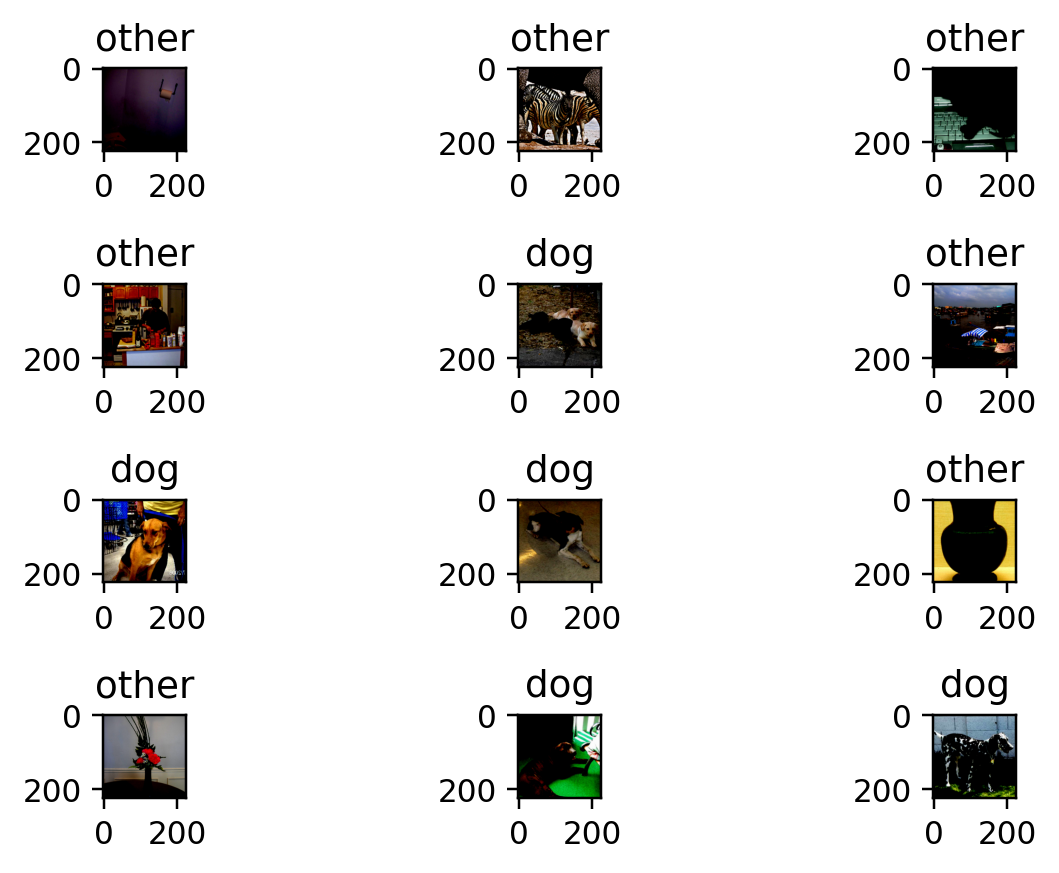

In [26]:
columns = 3
rows = 4
fig, ax = plt.subplots(rows, columns, dpi=224)
ax = ax.ravel()
for i, (image, labels) in enumerate(train_loader):
    if i == rows:
        break
    for j, (img) in enumerate(image):
        np_array = img.numpy()
        np_array = np_array.swapaxes(0, 2)
        np_array = np.rot90(np_array, 3)
        ax[i*columns+j].imshow(np_array)
        ax[i*columns+j].set_title(all_classes[labels[j]]) # set title
fig.tight_layout()
plt.show()

## Both Phases

### Training phase
* `labels_start_at` is used if all labels start at 1 instead of 0
* `print_every_x_percent` states when the current accuracy and loss gets printed and the accuracy and loss graph are updated in tensor board

In the training phase of the model a progress bar with the remaining time as well as the accuracy and loss is displayed. After every epoch a confusion matrix is generated for tensor board as well as a plot visible in an output console.
Info: If an image dataset with a similar size is used, then `device="dml"` or `device="cuda"` is the fastest device for the confusion matrix as well as the training phase. If the dataset is smaller then `device=cpu` could be faster, because the tensors don't need to be moved between GPU and CPU, but in most cases the device needs to be on the GPU.

Epoch [1/1], Step [1040/10400], Accuracy: 0.3603, Loss: 1.0998                                                  

Epoch [1/1], Step [2080/10400], Accuracy: 0.3401, Loss: 1.4876                                                  

Epoch [1/1], Step [3120/10400], Accuracy: 0.3529, Loss: 1.1327                                                  



C:\Users\matri\miniconda3\envs\pydml\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/1], Step [4160/10400], Accuracy: 0.3381, Loss: 0.9106                                                  

Epoch [1/1], Step [5200/10400], Accuracy: 0.3481, Loss: 1.0185                                                  

Epoch [1/1], Step [6240/10400], Accuracy: 0.3580, Loss: 0.9286                                                  

Epoch [1/1], Step [7280/10400], Accuracy: 0.3574, Loss: 1.0782                                                  

Epoch [1/1], Step [8320/10400], Accuracy: 0.3455, Loss: 1.3443                                                  

Epoch [1/1], Step [9360/10400], Accuracy: 0.3497, Loss: 1.5993                                                  

Epoch [1/1], Step [10400/10400], Accuracy: 0.3388, Loss: 1.4327                                                  

[████████████████████████████████████████████████████████████] 100.0% ...remaining Time: 0.3s

####################################Training Completed#####################################

Creating Conf

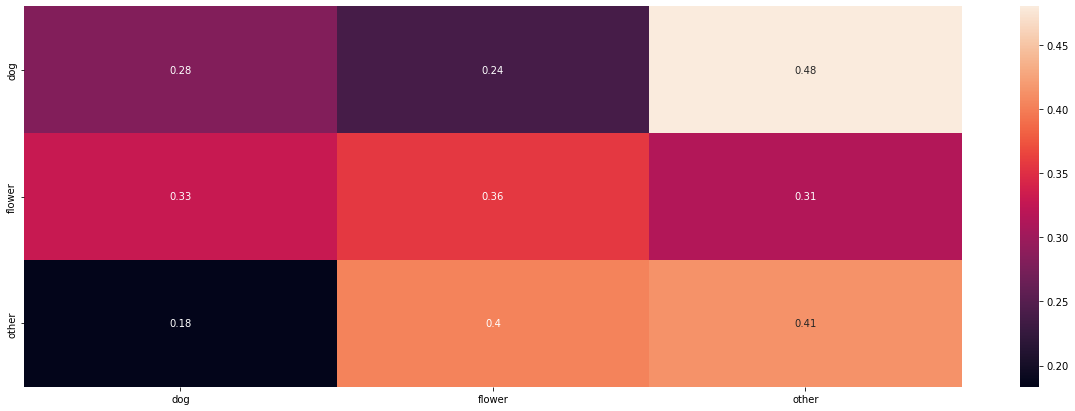

Epoch [1/1], Step [1040/10400], Accuracy: 0.2718, Loss: 1.0750                                                  



C:\Users\matri\miniconda3\envs\pydml\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/1], Step [2080/10400], Accuracy: 0.2689, Loss: 0.7527                                                  

Epoch [1/1], Step [3120/10400], Accuracy: 0.2654, Loss: 1.3513                                                  

Epoch [1/1], Step [4160/10400], Accuracy: 0.2590, Loss: 1.3006                                                  

Epoch [1/1], Step [5200/10400], Accuracy: 0.2718, Loss: 1.1735                                                  

Epoch [1/1], Step [6240/10400], Accuracy: 0.2689, Loss: 1.5373                                                  

Epoch [1/1], Step [7280/10400], Accuracy: 0.2744, Loss: 0.7170                                                  

Epoch [1/1], Step [8320/10400], Accuracy: 0.2660, Loss: 1.1326                                                  

Epoch [1/1], Step [9360/10400], Accuracy: 0.2692, Loss: 1.2550                                                  

Epoch [1/1], Step [10400/10400], Accuracy: 0.2532, Loss: 1.1289                         

In [13]:
labels_start_at = 0
print_every_x_percent = 0.1

model = trainingPhase(model, criterion, optimizer, train_loader, num_epochs, print_every_x_percent, save_trained_model, device, confusionmatrixdevice, writer, FILE, all_classes, labels_start_at)

### Testing phase
* `output_examples_check` is used to determine if an output should be given for displaying all false guessed batches by the model

In the testing phase of the model a progress bar with the remaining time is displayed. At the end a confusion matrix is generated for tensor board as well as a plot visible in the outputs.



Starting with Testing!

Creating Confusion Matrix ...
[████████████████████████████████████████████████████████████] 100.0% ...remaining Time: 0.6s



#####################################Statistics############################################

Accuracy of the network on dog: 26.5 % (530/2000)

Accuracy of the network on flower: 31.65 % (633/2000)

Accuracy of the network on other: 40.2 % (804/2000)

Accuracy of the network on all: 32.78333333333333 % (1967/6000)



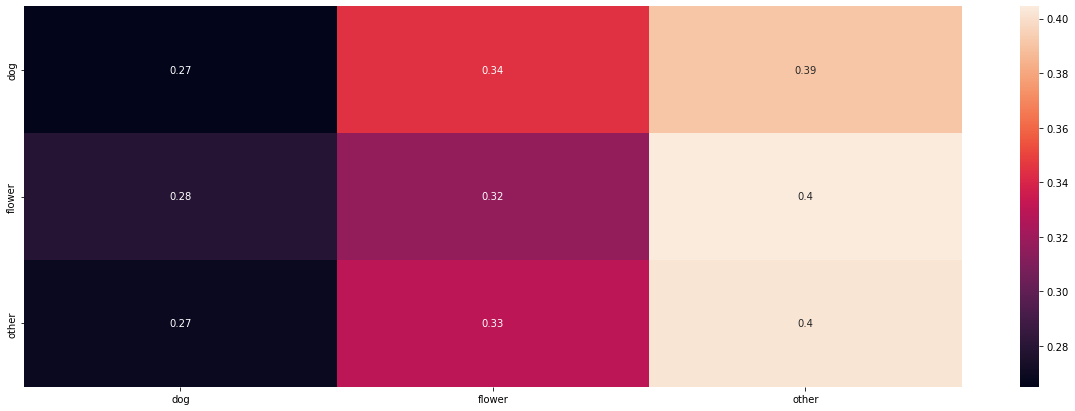

In [14]:
output_examples_check = 0

testingPhase(model, test_loader, writer, FILE, all_classes, labels_start_at, confusionmatrixdevice, output_examples_check)